# Exploration of high-dimensional analysis of primary cultures spike train data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

#### Overview of the data

In [2]:
data = np.load('sorted_baseline.npz', allow_pickle=True)

keys = list(data.keys())

for key in keys:
    content = data[key]
    print(key.ljust(10),
          str(np.shape(content)).ljust(10),
          str(type(content)))
    
units = data['units']
locations = data['locations']
samplerate = int(data['fs'])

units      (302,)     <class 'numpy.ndarray'>
locations  (972, 2)   <class 'numpy.ndarray'>
fs         ()         <class 'numpy.ndarray'>


In [3]:
units_keys = units[0].keys()

print('Units consists of an array of dictionary with more data', end='\n\n')

for key in units_keys:
    content = units[1][key]
    print(key.ljust(12),
          str(np.shape(content)).ljust(12),
          str(type(content)))

Units consists of an array of dictionary with more data

unit_id      ()           <class 'int'>
spike_train  (353,)       <class 'numpy.ndarray'>
x_max        ()           <class 'numpy.float64'>
y_max        ()           <class 'numpy.float64'>
template     (141, 972)   <class 'numpy.memmap'>
electrode    ()           <class 'numpy.int32'>


### Pre-processing the data

Order the data from most to least active unit and obtain the last frame (`total_size`) at which a firing happened, i.e. the total number of frames. 

In [4]:
activity = np.array([])
total_size = 0

for unit in units:
    activity = np.append(activity, len(unit['spike_train']))

    try:
        if unit['spike_train'][-1] > total_size:
            total_size = unit['spike_train'][-1]
    except:
        continue
 

unit_number = np.arange(0, len(units))
units = units[np.argsort(-1*activity)]

Create a binary array of size `(#units, total_size)` with a value `1` if the unit has fired, and `0` if it did not fire. 

In [5]:
binary_firings = np.full( (len(units), total_size+1), False, dtype=np.bool_)

for i, unit in enumerate(units):
    binary_firings[i][unit['spike_train']] = True

From this binary array we can obtain the firing rate per frame by summing over all units each time step. Because of the high frame rate this gives a very noisy output. We therefore take a running average. To reduce the amount of data and computation time we take an average every `step` frames. 

In [6]:
firing_rate = np.sum(binary_firings, axis=0) #get firing rate per frame

window_size = 0.02 # seconds
window = samplerate * window_size # window in number of frames
step = window / 20

time = np.arange(0, len(firing_rate)/samplerate, 1/samplerate)

firing_rate_avg = []
time_avg = []

for i in range(0, len(firing_rate), int(step)):

    firing_rate_avg.append(np.sum(firing_rate[i:i+int(window)])/window_size)
    
    time_avg.append(time[i]+window_size)

firing_rate_avg = np.array(firing_rate_avg)
time_avg = np.array(time_avg)


Now we can plot the data

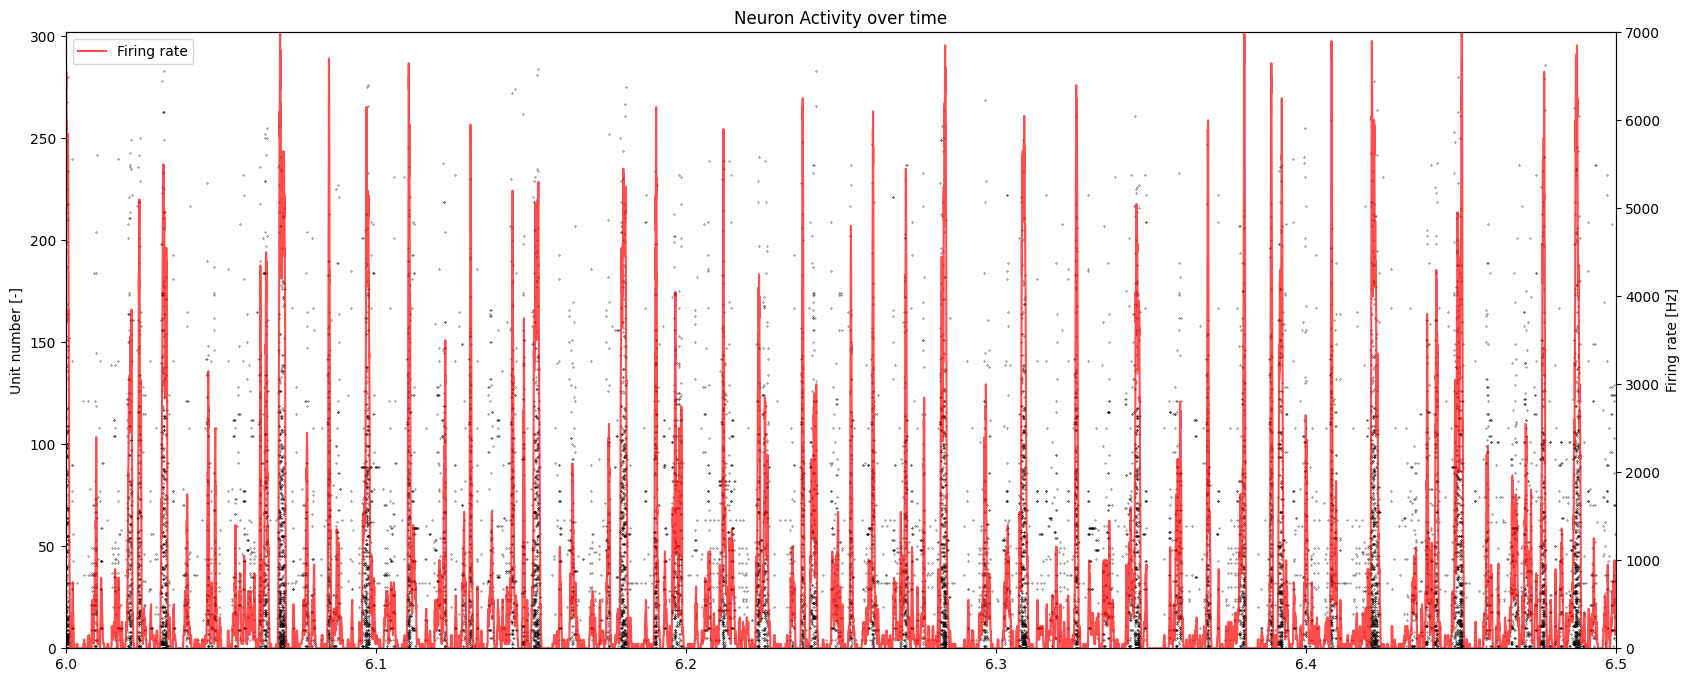

Total measurement time: 15 min 0.043 s


In [7]:
fig, ax1 = plt.subplots(figsize=(20, 8))

plt.title('Neuron Activity over time')

for i, unit in enumerate(units):
    ax1.scatter(unit['spike_train']/samplerate/60, 
                np.full_like(unit['spike_train'], unit_number[i]), 
                s=.07, color='k')

ax1.set_ylabel('Unit number [-]')
ax1.set_ylim(0, len(units))

ax2 = ax1.twinx() 
ax2.plot(time_avg/60, firing_rate_avg, c='r', alpha=.7, label='Firing rate')
ax2.set_ylim(0, 7000)
ax2.set_ylabel('Firing rate [Hz]')
ax2.legend()

plt.xlabel('Time [min]')
plt.xlim(6, 6.5)
plt.show()

print(f'Total measurement time: {int(time[-1]//60)} min {round(time[-1]%60, 3)} s')

### Implementing TJ method of obtaining firing rates
First apply the method to a few spike trains to see how it works

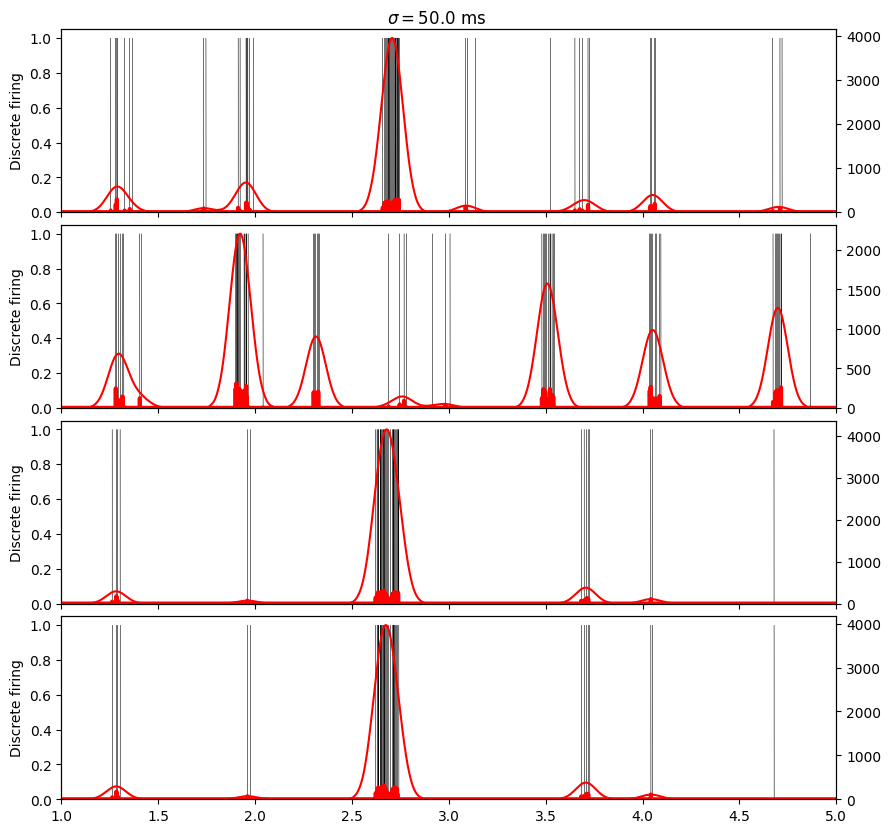

In [ ]:
def gaussian_kernel(size, sigma):
    x = np.linspace(-size // 2, size // 2, int(size))
    kernel = np.exp(-x**2 / (2 * sigma**2))
    return kernel

def convolution(input, kernel, stride=1, padding='same'):
    input_length = len(input)
    kernel_length = len(kernel)
    output_length = (input_length - kernel_length) // stride + 1

    if padding == 'same':
        pad_size = (kernel_length - 1) // 2
        input = np.pad(input, (pad_size, pad_size), mode='constant')
    elif padding == 'valid':
        pad_size = 0
    else:
        raise ValueError("Padding must be either 'same' or 'valid'")
    
    padded_input_length = len(input)

    output_length = (padded_input_length - kernel_length) // stride + 1

    output = np.zeros(output_length)

    for i in range(0, output_length):
        start_index = i * stride
        output[i] = np.dot(input[start_index:start_index + kernel_length], kernel)

    return output


kernel_size = .3 # seconds
sigma = .05 # seconds
stride = 50 # seconds * samplerate
gaussian = gaussian_kernel(kernel_size*samplerate, sigma*samplerate)

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
plt.subplots_adjust(hspace=.07)
plt.suptitle(r'$\sigma =$'+str(sigma*1e3)+' ms', y=.9)

time_xlim = (1, 5)

for i, ax in enumerate(axs):

    spike_train = units[i]['spike_train']
    isi = np.diff(spike_train)
    isi_rate = 1/(isi/samplerate)

    firing_rate_binary = np.zeros(total_size)
    
    firing_rate_binary[spike_train[:-1]] = isi_rate

    # only convolve and plot part to save time
    index_min = np.argmin(np.abs(time - time_xlim[0]))
    index_max = np.argmin(np.abs(time - time_xlim[1]))

    firing_rate_smooth = convolution(firing_rate_binary[index_min:index_max], gaussian, stride=stride)

    ax.plot(time[index_min:index_max], binary_firings[i][index_min:index_max], c='k', alpha=1, linewidth=.2)

    axright = ax.twinx()
    
    axright.plot(time[index_min:index_max], firing_rate_binary[index_min:index_max], c='r', linewidth=3)
    axright.plot(time[index_min:index_max:stride], firing_rate_smooth, c='r')
    axright.set_ylim(0)
    ax.set_ylabel('Discrete firing')
    ax.set_ylim(0)

plt.xlabel('Time [ms]')
plt.xlim(time_xlim)
plt.show()

In [9]:
for i, unit in tqdm(enumerate(units)):

    spike_train = np.unique(unit['spike_train'])
    isi = np.diff(spike_train)
    isi_rate = 1/(isi/samplerate)    

    firing_rate_binary = np.zeros(total_size)
    
    firing_rate_binary[spike_train[:-1]] = isi_rate

    firing_rate_smooth = convolution(firing_rate_binary, gaussian, stride=stride)

    if i==0:
        firing_rates = firing_rate_smooth
    else:
        firing_rates = np.vstack((firing_rates, firing_rate_smooth))


302it [03:58,  1.26it/s]


(array([1.0056e+04, 4.1800e+02, 2.2900e+02, 1.9100e+02, 1.6600e+02,
        1.7200e+02, 1.6400e+02, 1.5900e+02, 1.4600e+02, 1.0000e+02,
        8.5000e+01, 6.2000e+01, 3.4000e+01, 2.0000e+01, 1.9000e+01,
        1.2000e+01, 1.2000e+01, 6.0000e+00, 3.0000e+00, 6.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.70000e+01, 1.43740e+03, 2.82780e+03, 4.21820e+03, 5.60860e+03,
        6.99900e+03, 8.38940e+03, 9.77980e+03, 1.11702e+04, 1.25606e+04,
        1.39510e+04, 1.53414e+04, 1.67318e+04, 1.81222e+04, 1.95126e+04,
        2.09030e+04, 2.22934e+04, 2.36838e+04, 2.50742e+04, 2.64646e+04,
        2.78550e+04, 2.92454e+04, 3.06358e+04, 3.20262e+04, 3.34166e+04,
        3.48070e+04, 3.61974e+04, 3.75878e+04, 3.89782e+04, 4.03686e+04,
        4.17590e

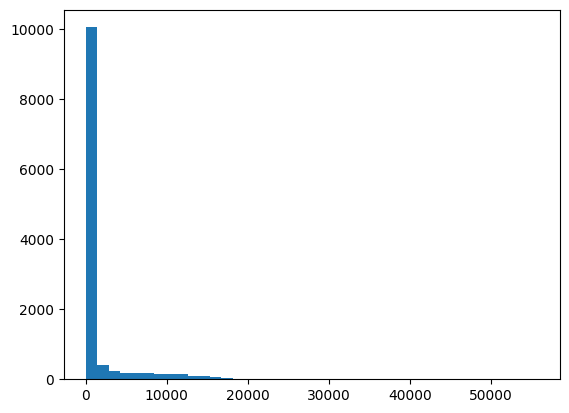

In [12]:
spike_train = units[0]['spike_train']
isi = np.diff(spike_train)
plt.hist(isi, bins=40)

In [10]:
np.savetxt('firing_rates_smooth_50ms.csv', firing_rates, delimiter=',')

In [11]:
firing_rates = np.loadtxt('firing_rates_smooth_50ms.csv', delimiter=',')

#### PCA

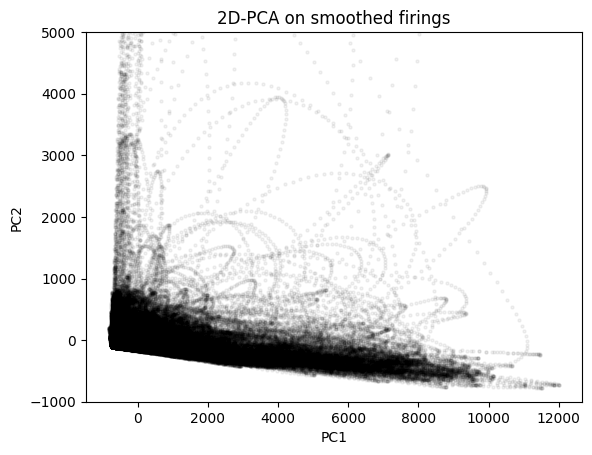

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
PCA_smooth_2d = pca.fit_transform(firing_rates.T)

plt.figure()
plt.title('2D-PCA on smoothed firings')
plt.scatter(PCA_smooth_2d[:,0], PCA_smooth_2d[:,1], s=5, alpha=.05, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
plt.ylim(-1000, 5000)
plt.show()

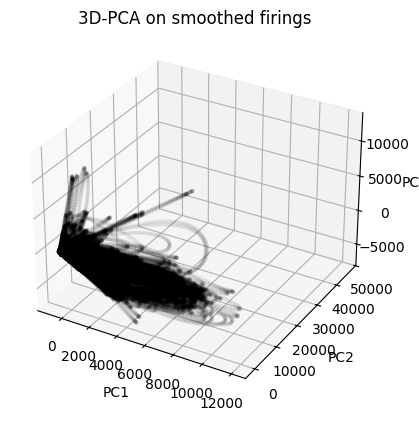

In [13]:
pca = PCA(n_components=3)
PCA_smooth_3d = pca.fit_transform(firing_rates.T)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-PCA on smoothed firings')
ax.scatter(PCA_smooth_3d[:,0], PCA_smooth_3d[:,1], PCA_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

#### t-SNE

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firing_rates[:,:1000].T)

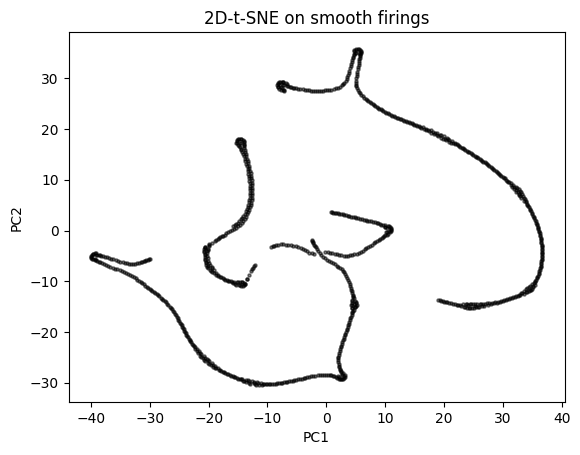

In [15]:
plt.figure()
plt.title('2D-t-SNE on smooth firings')
plt.scatter(tsne_smooth_2d[:,0], tsne_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-200, 200)
#plt.ylim(-200, 200)
plt.show()

In [16]:
tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firing_rates.T)

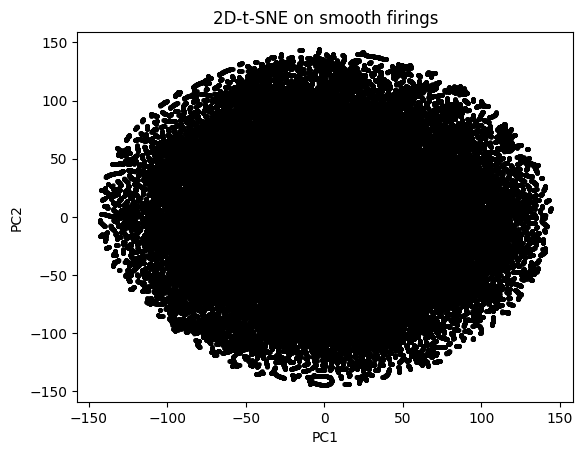

In [17]:
plt.figure()
plt.title('2D-t-SNE on smooth firings')
plt.scatter(tsne_smooth_2d[:,0], tsne_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-200, 200)
#plt.ylim(-200, 200)
plt.show()

In [18]:
tsne = TSNE(n_components=3)
tsne_smooth_3d = tsne.fit_transform(firing_rates.T)

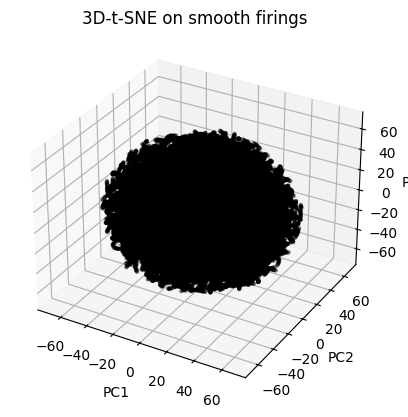

In [19]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-t-SNE on smooth firings')
ax.scatter(tsne_smooth_3d[:,0], tsne_smooth_3d[:,1], tsne_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.set_xlim(-10, 20)
#ax.set_ylim(-10, 20)
#ax.set_zlim(-20, 20)
plt.show()

Now lets zoom in on only a small part of the data

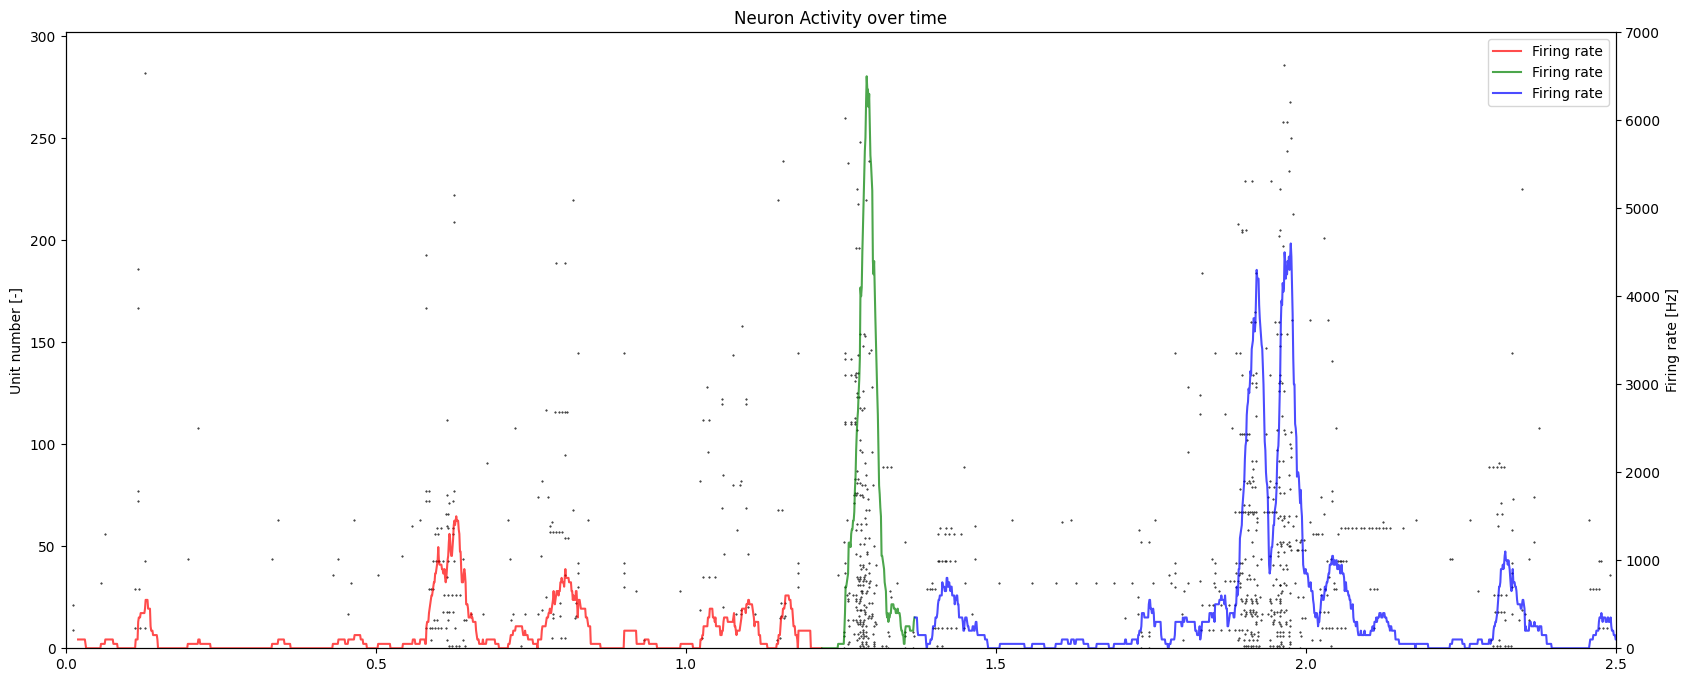

In [20]:
bereik = 50000

fig, ax1 = plt.subplots(figsize=(20, 8))

plt.title('Neuron Activity over time')

for i, unit in enumerate(units):
    spike_train = unit['spike_train']
    spike_train_sliced = spike_train[spike_train<=int(bereik)]
    ax1.scatter(spike_train_sliced/samplerate, 
                np.full_like(spike_train_sliced, unit_number[i]), 
                s=.2, color='k')

section1 = samplerate*np.array([0, 1.2]) # seconds
section2 = samplerate*np.array([1.2, 1.35]) # seconds
section3 = samplerate*np.array([1.35, 5]) # seconds

sections = np.array([section1, section2, section3]).astype(int)
sections_avg = (sections/step).astype(int)

colors = ['r', 'g', 'b']

ax1.set_ylabel('Unit number [-]')
ax1.set_ylim(0, len(units))

ax2 = ax1.twinx() 

for section, c in zip(sections_avg, colors):
    ax2.plot(time_avg[section[0]:section[1]], firing_rate_avg[section[0]:section[1]], c=c, alpha=.7, label='Firing rate')

ax2.set_ylim(0, 7000)
ax2.set_ylabel('Firing rate [Hz]')
ax2.legend()
plt.xlim(0, time[bereik])
plt.xlabel('Time [min]')
plt.show()

In [30]:
tsne = TSNE(n_components=2)
tsne_smooth_2d = tsne.fit_transform(firing_rates[:,:bereik//stride].T)

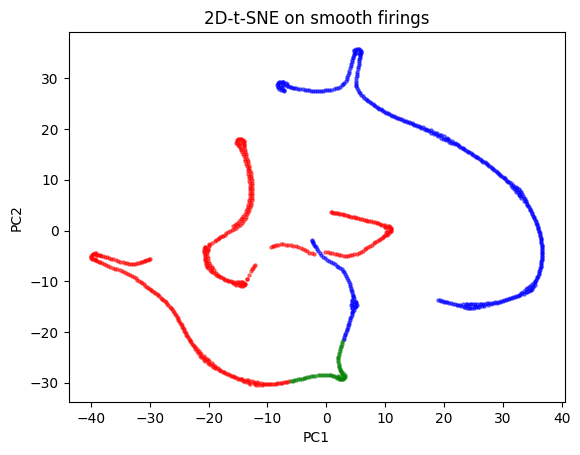

In [32]:
sections_tsne = (sections/stride).astype(int)

plt.figure()
plt.title('2D-t-SNE on smooth firings')
for section, c in zip(sections_tsne, colors):
    plt.scatter(tsne_smooth_2d[section[0]:section[1],0], tsne_smooth_2d[section[0]:section[1],1], s=5, alpha=.5, c=c)
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-1e3, 6e3)
#plt.ylim(-1e3, 3e3)
plt.show()

In [23]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2)
umap_smooth_2d = umap_model.fit_transform(firing_rates.T)

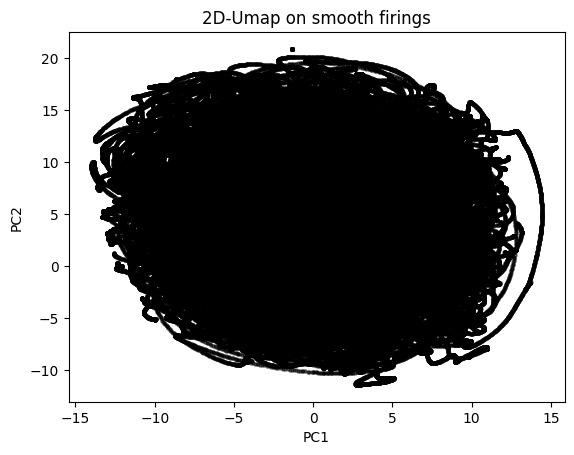

In [24]:
plt.figure()
plt.title('2D-Umap on smooth firings')
plt.scatter(umap_smooth_2d[:,0], umap_smooth_2d[:,1], s=5, alpha=.5, c='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
#plt.xlim(-.01, .2)
#plt.ylim(-0.01, .4)
plt.show()

In [25]:
umap_model = umap.UMAP(n_components=3)
umap_smooth_3d = umap_model.fit_transform(firing_rates.T)

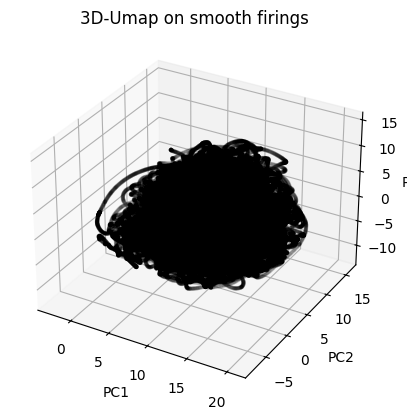

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D-Umap on smooth firings')
ax.scatter(umap_smooth_3d[:,0], umap_smooth_3d[:,1], umap_smooth_3d[:,2], s=5, c='k', marker='o', alpha=.05)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()